In [6]:
import chess
from ChessWrapper import ChessWrapper
from copy import deepcopy
from material_values import *
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [42]:
import pickle

In [7]:
%autosave 120

Autosaving every 120 seconds


In [8]:
pd.set_option('display.max_rows', 500)

In [9]:
def get_num_pieces(state):
        # get pawn counts
        wp = len(state.pieces(chess.PAWN, chess.WHITE))
        bp = len(state.pieces(chess.PAWN, chess.BLACK))
        
        # get knight counts
        wn = len(state.pieces(chess.KNIGHT, chess.WHITE))
        bn = len(state.pieces(chess.KNIGHT, chess.BLACK))

        # get bishop counts
        wb = len(state.pieces(chess.BISHOP, chess.WHITE))
        bb = len(state.pieces(chess.BISHOP, chess.BLACK))

        # get rook counts
        wr = len(state.pieces(chess.ROOK, chess.WHITE))
        br = len(state.pieces(chess.ROOK, chess.BLACK))

        # get queen counts
        wq = len(state.pieces(chess.QUEEN, chess.WHITE))
        bq = len(state.pieces(chess.QUEEN, chess.BLACK))
        
        return (
            (wp, P_PHASE), 
            (bp, P_PHASE), 
            (wn, N_PHASE), 
            (bn, N_PHASE), 
            (wb, B_PHASE), 
            (bb, B_PHASE), 
            (wr, R_PHASE), 
            (br, R_PHASE), 
            (wq, Q_PHASE), 
            (bq, Q_PHASE)
        )
    
def get_phase(state):
    phase = TOTAL_PHASE
    pieces = get_num_pieces(state)

    for num_pieces, phase_val in pieces:
        # more pieces = lower phase value
        # higher phase value = closer to endgame
        phase -= num_pieces * phase_val

    phase = (phase/TOTAL_PHASE) # scale with highest possible phase value
    return phase

def evaluate_piece(piece, square, phase):
    mg_score = 0
    eg_score = 0
    if piece.color == chess.WHITE:
        mg_score = MG_MAP[piece.piece_type][56 ^ square] + MG_VALUES[piece.piece_type]
        eg_score = EG_MAP[piece.piece_type][56 ^ square] + EG_VALUES[piece.piece_type]
    else:
        mg_score = MG_MAP[piece.piece_type][square] + MG_VALUES[piece.piece_type]
        eg_score = EG_MAP[piece.piece_type][square] + EG_VALUES[piece.piece_type]

    return mg_score * (1 - phase) + eg_score * (phase)

# return a static evaluation of the current position
def tapered_eval(state):
    
    outcome = state.outcome()
    if outcome is not None:
        if outcome.winner == chess.WHITE:
            return BASE_VALUES[chess.KING]
        elif outcome.winner == chess.BLACK:
            return -BASE_VALUES[chess.KING]
        else: # draw
            return 0 
    phase = get_phase(state)

    material_counts = {
        chess.WHITE : 0,
        chess.BLACK : 0
    }

    # python-chess defines A1 as 0, H8 as 63
    for square in range(64):
        piece = state.piece_at(square)
        if piece is None: # skip trying to evaluate empty squares
            continue
        piece_val = evaluate_piece(piece, square, phase)
        if piece.color == chess.WHITE:
            material_counts[chess.WHITE] += piece_val
        else:
            material_counts[chess.BLACK] += piece_val

    return material_counts[chess.WHITE] - material_counts[chess.BLACK]

In [10]:
# state is a ChessWrapper state
# TODO: check if this works for checked positions, checkmate positions, statemate positions

# return: white's mobility - black's mobility
def mobility(state):
    
    mobility1 = len(state.get_legal_moves())
    # Change side to move by pushing a null move and calculate all moves for opponent
    state.push(chess.Move.null())
    
    mobility2 = len(state.get_legal_moves())
    
    # Take back the null move to reset the board back to the position
    state.pop()

    # if turn is white, mobility 1 represents white's mobility
    mobility_delta = mobility1 - mobility2 
    if state.get_turn() == chess.BLACK:
        mobility_delta *= -1
    return mobility_delta

In [11]:
def control_feat(state):
    control = {
        chess.WHITE : {
            'total' : 0, # total number of spaces controlled
            'center' : 0, # number of center spaces controlled
            'space' : 0 # number of spaces on opposition side controlled
        },
        chess.BLACK : {
            'total' : 0,
            'center' : 0,
            'space' : 0
        }
    }
    
    for square in range(64):
        piece = state.piece_at(square)
        white_attackers = state.attackers(chess.WHITE, square)
        black_attackers = state.attackers(chess.BLACK, square)
        
        attack_delta = len(white_attackers) - len(black_attackers)
        
        
        if attack_delta > 0: # white has more pieces targeting square
            if square == chess.E4 or square == chess.E5 or square == chess.D4 or square == chess.D5:
                control[chess.WHITE]['center'] += 1
            if square > chess.H4:
                control[chess.WHITE]['space'] += 1
            control[chess.WHITE]['total'] += 1
        elif attack_delta < 0: # black has more pieces targeting square
            if square == chess.E4 or square == chess.E5 or square == chess.D4 or square == chess.D5:
                control[chess.BLACK]['center'] += 1
            if square <= chess.H4:
                control[chess.BLACK]['space'] += 1
            control[chess.BLACK]['total'] += 1
    return control

In [12]:
def doubled_pawns(board, color):
    p_bb = int(board.pieces(chess.PAWN, color)) # get the pawn bitboard
    rows = []
    while p_bb > 0:
        row = p_bb & 0b11111111 # get bottom row       
        p_bb = p_bb >> 8 # remove bottom row
        
        if row > 0:
            rows.append(row) # ignore the rows that are blank
            
    num_doubled = 0
    #print(rows)
    for i in range(len(rows) - 1):
        for j in range(i + 1, len(rows)):
            compared = rows[i] & rows[j]
            
            if (compared) > 0: # compare each pair of rows
                num_doubled += compared.bit_count() # if two rows have multiple pawns lined up
    return num_doubled

In [13]:
def pawn_islands(board, color):
    p_bb = int(board.pieces(chess.PAWN, color)) # get the pawn bitboard
    
    res = 0
    while p_bb > 0:
        row = p_bb & 0b11111111 # get bottom row       
        p_bb = p_bb >> 8 # remove bottom row
        res = res | row
    
    curr_run = 0
    islands = 0
    while res > 0:
        if res & 1 == 1:
            curr_run += 1
        else:
            if curr_run >= 1:
                islands += 1
                curr_run = 0
        res = res >> 1
    if curr_run >= 1:
        islands += 1
    return islands

In [14]:
def passers(board, color):
    p1_p_bb = int(board.pieces(chess.PAWN, color))
    p2_p_bb = int(board.pieces(chess.PAWN, not color))
    
    p1_rows = []
    p2_rows = []
    for i in range(8):
        row = p1_p_bb & 0b11111111 # get bottom row       
        p1_p_bb = p1_p_bb >> 8 # remove bottom row
        p1_rows.append(row)
        #print('{:08b}'.format(row))
        
    #print('------------')
    for i in range(8):
        row = p2_p_bb & 0b11111111 # get bottom row       
        p2_p_bb = p2_p_bb >> 8 # remove bottom row
        p2_rows.append(row)
        #print('{:08b}'.format(row))
        
    if color == chess.BLACK:
        p1_rows.reverse()
        p2_rows.reverse()
        
    passers = 0
    for r in range(1, 7):
        blockers = 0
        if p1_rows[r] > 0:
            for r2 in range(r + 1, 7):
                # for each row ahead of the p1's current row, check if there's a blocker
                blockers = blockers | p2_rows[r2] | (p2_rows[r2] << 1) | (p2_rows[r2] >> 1)
        passers += (~blockers & p1_rows[r]).bit_count()
    
    return passers

In [15]:
# def get_features(board):

#     control = control_feat(board)    
#     new_row = pd.DataFrame(
#         {
#             'tapered_eval': [tapered_eval(board)],
#             'mobility' : [mobility(board)],
#             'total_control' : [control[chess.WHITE]['total'] - control[chess.BLACK]['total']],
#             'center_control' : [control[chess.WHITE]['center'] - control[chess.BLACK]['center']],
#             'space_control' : [control[chess.WHITE]['space'] - control[chess.BLACK]['space']],
#             'pawn_islands' : [pawn_islands(board, chess.WHITE) - pawn_islands(board, chess.BLACK)],
#             'doubled_pawns' : [doubled_pawns(board, chess.WHITE) - doubled_pawns(board, chess.BLACK)],
#             'passed_pawns' : [passers(board, chess.WHITE) - passers(board, chess.BLACK)]
#         }
#     )
    
#     return new_row

In [16]:
sf_data = pd.read_csv('chessData2.csv', encoding='utf-8')

In [17]:
# parse checkmate (#) in Evaluation
def parse_eval(ev):
    # if checkmate, just give one side a massive numeric advantage
    # ex: if white has #100, then it translates to 100000 centipawns
    # which would be a positional adv of 1000
    if ev[0] == '#':
        ev = ev[1:] + '000'
    ev = eval(ev)
    return ev

In [18]:
sf_data['Evaluation'] = sf_data['Evaluation'].apply(parse_eval)

In [21]:
def create_features(data_df):
    features_df = pd.DataFrame()
    counter = 0
    for idx, row in data_df.iterrows():
        board = ChessWrapper(row['FEN'])
        
        control = control_feat(board)
        
        if row['Evaluation'] >= 200:
            target = 1
        elif row['Evaluation'] <= 200:
            target = 0
        
        new_row = pd.DataFrame(
            {
                'FEN' : row['FEN'],
                'tapered_eval': [tapered_eval(board)],
                'mobility' : [mobility(board)],
                'total_control' : [control[chess.WHITE]['total'] - control[chess.BLACK]['total']],
                'center_control' : [control[chess.WHITE]['center'] - control[chess.BLACK]['center']],
                'space_control' : [control[chess.WHITE]['space'] - control[chess.BLACK]['space']],
                'pawn_islands' : [pawn_islands(board, chess.WHITE) - pawn_islands(board, chess.BLACK)],
                'doubled_pawns' : [doubled_pawns(board, chess.WHITE) - doubled_pawns(board, chess.BLACK)],
                'passed_pawns' : [passers(board, chess.WHITE) - passers(board, chess.BLACK)],
                'sf_evaluation' : row['Evaluation'],
                'target' : target
            }
        )
        features_df = pd.concat([features_df, new_row])
        counter += 1
        if counter % 1000 == 0:
            print (counter)
    return features_df.reset_index(drop=True)

#### Try Regression instead of classification? maybe it will be slightly more informative?

In [23]:
reg_data = sf_data.sample(n=200000, random_state=0)

In [24]:
try:
    reg_feat = pd.read_csv('reg_feat.csv')
    reg_feat = reg_feat.drop(columns=['Unnamed: 0'])
except:
    reg_feat = create_features(reg_data)

In [25]:
reg_feat

,FEN,tapered_eval,mobility,total_control,center_control,space_control,pawn_islands,doubled_pawns,passed_pawns,sf_evaluation,target
0,8/2pq2k1/p4pp1/n7/P4Q2/2Pr3P/5PP1/4R1K1 w - - ...,-191.572115,1,-4,1,-3,0,0,0,-446,0
1,2b5/2q5/1p1p1k1p/2pP1p1P/2P5/2PnN1P1/5K2/1Q6 w...,-309.471154,-22,-1,-1,0,-1,1,0,0,0
2,5r2/pp3k1p/3p1p2/2pP1Ppb/P4n2/1P2R2P/1BQ2PPK/1...,179.144231,-1,-3,0,-2,1,1,0,784,1
3,7k/7p/1p2p3/p4q2/2Pp1p1Q/3PbPR1/PP6/5R1K b - -...,511.514423,9,3,-2,-2,-1,0,-1,93,0
4,4r1k1/pp4pp/1bp5/3p1Nq1/3P2r1/1Q2PR2/PP4PP/5RK...,3.000000,-5,-1,-1,-2,1,0,0,154,0
...,...,...,...,...,...,...,...,...,...,...,...
199995,r1b2rk1/p3q1p1/1p2P1pp/2pP3n/P7/2N1R1B1/1P4PP/...,103.807692,8,7,3,2,1,-1,2,438,1
199996,3r2k1/pp3pp1/4p2p/2Pr4/2P5/b3B2R/P3KPP1/1R6 b ...,-103.625000,0,-2,-2,4,1,1,0,-142,0
199997,r6r/p1B2kpp/5n2/3pN3/8/8/P2N1PPP/R4K2 b - - 3 19,164.615385,28,3,-1,4,-1,0,-1,254,1
199998,r6r/3qbkpp/1n2pp2/2pn4/1p5B/3Q1N2/PP2BPPP/3R1R...,27.865385,-12,-4,1,-3,0,0,0,-301,0


In [26]:
reg_feat = reg_feat.drop(columns=['FEN', 'target', 'center_control', 'total_control'])

In [27]:
reg_feat

,tapered_eval,mobility,space_control,pawn_islands,doubled_pawns,passed_pawns,sf_evaluation
0,-191.572115,1,-3,0,0,0,-446
1,-309.471154,-22,0,-1,1,0,0
2,179.144231,-1,-2,1,1,0,784
3,511.514423,9,-2,-1,0,-1,93
4,3.000000,-5,-2,1,0,0,154
...,...,...,...,...,...,...,...
199995,103.807692,8,2,1,-1,2,438
199996,-103.625000,0,4,1,1,0,-142
199997,164.615385,28,4,-1,0,-1,254
199998,27.865385,-12,-3,0,0,0,-301


In [28]:
reg_feat.describe()

,tapered_eval,mobility,space_control,pawn_islands,doubled_pawns,passed_pawns,sf_evaluation
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,23.853804,1.630140,0.369135,0.055725,-0.019795,0.037965,55.997575
std,589.253328,11.438887,2.836130,0.776552,0.488533,0.806683,1277.224768
min,-24000.000000,-59.000000,-24.000000,-4.000000,-4.000000,-6.000000,-38000.000000
25%,-51.030048,-5.000000,-1.000000,0.000000,0.000000,0.000000,-73.000000
50%,21.461538,2.000000,0.000000,0.000000,0.000000,0.000000,15.000000
75%,96.567308,8.000000,2.000000,1.000000,0.000000,0.000000,148.000000
max,24000.000000,62.000000,22.000000,4.000000,4.000000,6.000000,35000.000000


In [29]:
print(reg_feat['sf_evaluation'].quantile(.02))

print(reg_feat['sf_evaluation'].quantile(.98))

print(reg_feat['tapered_eval'].quantile(.02))

print(reg_feat['tapered_eval'].quantile(.98))

-1224.0
1606.0
-444.47798076923027
484.08903846153413


In [30]:
reg_feat['sf_evaluation'] = reg_feat['sf_evaluation'].clip(lower=-1500, upper=1500)

In [31]:
reg_feat['tapered_eval'] = reg_feat['tapered_eval'].clip(lower=-1500, upper=1500)

In [32]:
reg_feat.describe()

,tapered_eval,mobility,space_control,pawn_islands,doubled_pawns,passed_pawns,sf_evaluation
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,21.133501,1.630140,0.369135,0.055725,-0.019795,0.037965,42.308620
std,207.067362,11.438887,2.836130,0.776552,0.488533,0.806683,431.783633
min,-1500.000000,-59.000000,-24.000000,-4.000000,-4.000000,-6.000000,-1500.000000
25%,-51.030048,-5.000000,-1.000000,0.000000,0.000000,0.000000,-73.000000
50%,21.461538,2.000000,0.000000,0.000000,0.000000,0.000000,15.000000
75%,96.567308,8.000000,2.000000,1.000000,0.000000,0.000000,148.000000
max,1500.000000,62.000000,22.000000,4.000000,4.000000,6.000000,1500.000000


In [33]:
# try squared features??

reg_feat['m2'] = np.square(reg_feat['mobility']) * np.sign(reg_feat['mobility'])
reg_feat['sc2'] = np.square(reg_feat['space_control']) * np.sign(reg_feat['space_control'])
reg_feat['pi2'] = np.square(reg_feat['pawn_islands']) * np.sign(reg_feat['pawn_islands'])
reg_feat['dp2'] = np.square(reg_feat['doubled_pawns']) * np.sign(reg_feat['doubled_pawns'])
reg_feat['pp2'] = np.square(reg_feat['passed_pawns']) * np.sign(reg_feat['passed_pawns'])

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [37]:
reg_feat2 = reg_feat.drop(columns=['passed_pawns', 'mobility', 'space_control', 'doubled_pawns', 'pawn_islands'])

In [38]:
reg_feat2

,tapered_eval,sf_evaluation,m2,sc2,pi2,dp2,pp2
0,-191.572115,-446,1,-9,0,0,0
1,-309.471154,0,-484,0,-1,1,0
2,179.144231,784,-1,-4,1,1,0
3,511.514423,93,81,-4,-1,0,-1
4,3.000000,154,-25,-4,1,0,0
...,...,...,...,...,...,...,...
199995,103.807692,438,64,4,1,-1,4
199996,-103.625000,-142,0,16,1,1,0
199997,164.615385,254,784,16,-1,0,-1
199998,27.865385,-301,-144,-9,0,0,0


In [39]:
reg_feat2.describe()

,tapered_eval,sf_evaluation,m2,sc2,pi2,dp2,pp2
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,21.133501,42.308620,26.810070,1.340055,0.065155,-0.022435,0.038615
std,207.067362,431.783633,313.140266,17.332379,1.130237,0.645890,1.676871
min,-1500.000000,-1500.000000,-3481.000000,-576.000000,-16.000000,-16.000000,-36.000000
25%,-51.030048,-73.000000,-25.000000,-1.000000,0.000000,0.000000,0.000000
50%,21.461538,15.000000,4.000000,0.000000,0.000000,0.000000,0.000000
75%,96.567308,148.000000,64.000000,4.000000,1.000000,0.000000,0.000000
max,1500.000000,1500.000000,3844.000000,484.000000,16.000000,16.000000,36.000000


In [46]:
reg_feat2.corr()

,tapered_eval,sf_evaluation,m2,sc2,pi2,dp2,pp2
tapered_eval,1.000000,0.498169,0.322619,0.455072,0.111578,0.089216,0.205344
sf_evaluation,0.498169,1.000000,0.237633,0.354745,0.093768,0.032059,0.243037
m2,0.322619,0.237633,1.000000,0.305544,-0.006832,0.002167,0.029277
sc2,0.455072,0.354745,0.305544,1.000000,0.067759,0.052913,0.116366
pi2,0.111578,0.093768,-0.006832,0.067759,1.000000,0.146536,0.485581
dp2,0.089216,0.032059,0.002167,0.052913,0.146536,1.000000,0.083491
pp2,0.205344,0.243037,0.029277,0.116366,0.485581,0.083491,1.000000


220.13339793472466
219.43236727476503


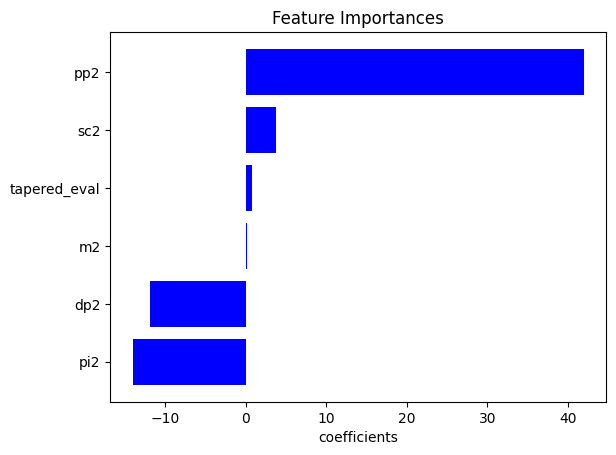

In [40]:
X_train_reg2, X_test_reg2, y_train_reg2, y_test_reg2 = train_test_split(reg_feat2.drop(columns='sf_evaluation'), reg_feat2['sf_evaluation'], test_size=.25, random_state=42)


lin_reg2 = LinearRegression()

lin_reg2.fit(X_train_reg2, y_train_reg2)


y_train_pred_linreg2 = lin_reg2.predict(X_train_reg2)

y_test_pred_linreg2 = lin_reg2.predict(X_test_reg2)

mean_squared_error(y_train_reg2, y_train_pred_linreg2)



print(mean_absolute_error(y_train_reg2, y_train_pred_linreg2))

print(mean_absolute_error(y_test_reg2, y_test_pred_linreg2))

importances = lin_reg2.coef_
indices = np.argsort(importances)

features = X_train_reg2.columns.values

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('coefficients')
plt.show()

In [45]:
print(X_train_reg2.columns.values)

['tapered_eval' 'm2' 'sc2' 'pi2' 'dp2' 'pp2']


In [43]:
filename = 'lin_reg2.model'
pickle.dump(lin_reg2, open(filename, 'wb'))